In [1]:
import os
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.models as current_models
import torchvision.datasets as datasets
from utility import *


# parameter for net
device = "cuda:0"
learning_rate = 1e-4
momentum = 0.9
epochs = 20
batch_size = 10
display_step = 30
shuffle = True

# address
project_addrsss = os.getcwd()
train_dir = os.path.join(os.path.join(project_addrsss,"data"),"train")
val_dir = os.path.join(os.path.join(project_addrsss,"data"),"val")
parameter_address = os.path.join(os.path.join(project_addrsss, "model"), "parameters")
is_out_log_file = True

def val(model, loss_fn, dataloder, data_number):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for i, data in enumerate(dataloder):
            # get the inputs
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = model(inputs)
            # 计算损失
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()

    epoch_loss_val = running_loss / data_number
    epoch_acc_val = running_corrects / data_number
    return epoch_loss_val, epoch_acc_val


def train(epoch, model, optimizer, loss_fn, learning_rate, dataloder, data_number, log_address):
    model.train()
    adjust_learning_rate(optimizer, learning_rate, epoch)
    running_loss = 0.0
    running_corrects = 0
    # Iterate over data.
    for i, data in enumerate(dataloder):
        # 网络的前向传播
        inputs = data[0].to(device)
        labels = data[1].to(device)
        outputs = model(inputs)
        # 计算损失
        loss = loss_fn(outputs, labels)
        _, preds = torch.max(outputs.data, 1)
        # 记录当前batch_size的loss以及数据对应的分类准确数量
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
        if i % display_step == 0:
            print_and_log('\t{} {}-{}: Loss: {:.4f}'. format('train',epoch + 1, i, loss.item() / labels.size()[0]), is_out_log_file, log_address)
        
        # 先将网络中的所有梯度置0
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss_train = running_loss / data_number
    epoch_acc_train = running_corrects / data_number
    return epoch_loss_train, epoch_acc_train


def start_train(model, experiment_name = 'densenet161'):
    training_setup_seed(1)
    project_addrsss = os.getcwd()
    log_address = os.path.join(os.path.join(os.path.join(project_addrsss, "model"), "train_record"), experiment_name + "_log_file.txt")
    is_out_log_file = True
    # datasets
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
#         transforms.Normalize([0.3976813856328417], [0.05057423681276217]),
    ])
    image_datasets = {}
    image_datasets['train'] = datasets.ImageFolder(train_dir, transform=data_transforms)
    image_datasets['val'] = datasets.ImageFolder(val_dir, transform=data_transforms)
    dataloders = {}
    dataloders['train'] = DataLoader(
        image_datasets['train'],
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=1)
    dataloders['val'] = DataLoader(
        image_datasets['val'],
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=1)
    datasets_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    print_and_log("datasets size: {}".format(datasets_sizes), is_out_log_file, log_address)

    # models
    training_setup_seed(1)  # setup seed for all parameters, numpy.random, random, pytorch
    model.to(device)
    optimizer = optim.RMSprop(model.parameters(), learning_rate, momentum)
    loss_fn = nn.CrossEntropyLoss()
    max_val_acc = 0.0
    loss_train = []  # 训练集loss
    loss_val = []    # 验证集loss
    acc_train = []   # 训练集Acc
    acc_val = []     # 验证集Acc
    
    since = time.time()
    for epoch in range(epochs):
        print_and_log('Train Epoch {}/{}:'.format(epoch + 1, epochs), is_out_log_file, log_address)
        epoch_loss_train, epoch_acc_train = train(
            epoch, 
            model, 
            optimizer, 
            loss_fn, 
            learning_rate, 
            dataloders['train'], 
            datasets_sizes['train'],
            log_address)
        loss_train.append(epoch_loss_train)
        acc_train.append(epoch_acc_train)
        epoch_loss_val, epoch_acc_val = val(model, loss_fn, dataloders['val'], datasets_sizes['val'])
        loss_val.append(epoch_loss_val)
        acc_val.append(epoch_acc_val)
        print_and_log('\ttrain Loss: {:.6f}'.format(epoch_loss_train), is_out_log_file, log_address)
        print_and_log('\tvalidation Loss: {:.6f}'.format(epoch_loss_val), is_out_log_file, log_address)

        # deep copy the model
        if epoch_acc_val > max_val_acc:
            max_val_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print_and_log("Updating", is_out_log_file, log_address)
            torch.save(best_model_wts, os.path.join(parameter_address, experiment_name + '.pkl'))
        
        plot_loss(experiment_name, epoch, loss_train, loss_val, acc_train, acc_val)
        time_elapsed = time.time() - since
        print_and_log('Time passed {:.0f}h {:.0f}m {:.0f}s'.
                  format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60), is_out_log_file, log_address)
        print_and_log('-' * 20, is_out_log_file, log_address)
    print_and_log("train loss: {}".format(loss_train), is_out_log_file, log_address)
    print_and_log("train acc: {}".format(acc_train), is_out_log_file, log_address)
    print_and_log("val loss: {}".format(loss_val), is_out_log_file, log_address)
    print_and_log("val acc: {}".format(acc_val), is_out_log_file, log_address)
    print_and_log("max val acc: {}".format(max(acc_val)), is_out_log_file, log_address)

Epoch 19. train loss: 0.003445268548203602. val loss: 0.02647898528053397
Best val loss: 0.016516885837108343
Best val Acc: 0.9356223175965666
Back up
train_loss_list: [0.1677395632176131, 0.10501022607142177, 0.07741044407639443, 0.06671688168862337, 0.051016522162406285, 0.0431493741414508, 0.03303466489143034, 0.02725044742375342, 0.02092125194110044, 0.019853478642400293, 0.016238225880881835, 0.01237261388619885, 0.010664836433420326, 0.008565182877897188, 0.0059752998786544035, 0.004892284540331055, 0.006969897130575241, 0.0035251436329120514, 0.003454295961657867, 0.003445268548203602]
train_acc_list: [0.3738656987295826, 0.5934664246823956, 0.6978221415607986, 0.7513611615245009, 0.8239564428312159, 0.8566243194192378, 0.8865698729582577, 0.9192377495462795, 0.9455535390199638, 0.9337568058076225, 0.9591651542649727, 0.9745916515426497, 0.9764065335753176, 0.9818511796733213, 0.9918330308529946, 0.9945553539019963, 0.9882032667876588, 0.9954627949183303, 0.9945553539019963, 0.9

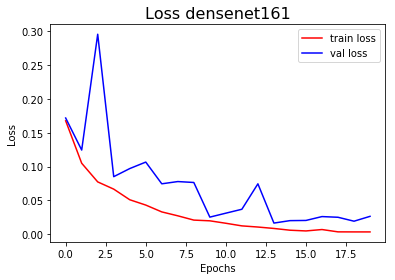

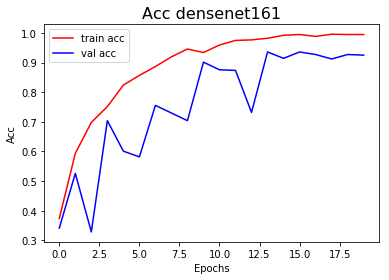

Time passed 0h 18m 30s
--------------------
train loss: [0.1677395632176131, 0.10501022607142177, 0.07741044407639443, 0.06671688168862337, 0.051016522162406285, 0.0431493741414508, 0.03303466489143034, 0.02725044742375342, 0.02092125194110044, 0.019853478642400293, 0.016238225880881835, 0.01237261388619885, 0.010664836433420326, 0.008565182877897188, 0.0059752998786544035, 0.004892284540331055, 0.006969897130575241, 0.0035251436329120514, 0.003454295961657867, 0.003445268548203602]
train acc: [0.3738656987295826, 0.5934664246823956, 0.6978221415607986, 0.7513611615245009, 0.8239564428312159, 0.8566243194192378, 0.8865698729582577, 0.9192377495462795, 0.9455535390199638, 0.9337568058076225, 0.9591651542649727, 0.9745916515426497, 0.9764065335753176, 0.9818511796733213, 0.9918330308529946, 0.9945553539019963, 0.9882032667876588, 0.9954627949183303, 0.9945553539019963, 0.9945553539019963]
val loss: [0.17187083944230633, 0.12449909701879444, 0.29574776616730913, 0.08513671968755804, 0.097

In [2]:
model = current_models.densenet161()
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 14)
start_train(model, experiment_name = 'densenet161')

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def analysis_in_testset(model, val_loader):
    model.eval()
    label_list=[]
    predict_list=[]
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            # get the inputs
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = model(inputs)
            # 计算损失
            _, preds = torch.max(outputs.data, 1)
            
            label_list.extend(labels.squeeze(0))
            predict_list.extend(preds.squeeze(0))
    label_list = list(map(lambda x:int(x), label_list))
    predict_list = list(map(lambda x:int(x), predict_list))
    return classification_report(label_list, predict_list), confusion_matrix(label_list, predict_list), label_list, predict_list

In [46]:

model = current_models.densenet161()
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 14)

model_path = os.path.join('model','parameters','densenet161.pkl')
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [47]:
project_addrsss = os.getcwd()
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
#         transforms.Normalize([0.3976813856328417], [0.05057423681276217]),
    ])
train_dir = os.path.join(os.path.join(project_addrsss,"data"),"train")
val_dir = os.path.join(os.path.join(project_addrsss,"data"),"val")
parameter_address = os.path.join(os.path.join(project_addrsss, "model"), "parameters")
is_out_log_file = True
image_datasets = {}
#image_datasets['train'] = datasets.ImageFolder(train_dir, transform=data_transforms)
image_datasets['val'] = datasets.ImageFolder(val_dir, transform=data_transforms)
val_loader= DataLoader(
        image_datasets['val'],
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=1)

In [49]:
score_table, c_mat, label, pred = analysis_in_testset(model, val_loader=val_loader)

In [44]:
with open('score_table.txt', 'w') as f:
        f.write(score_table)
f.close()
with open('pred_res.txt', 'w') as f:
    for x in zip(label, pred):
        f.write(str(x[0])+', '+str(x[1])+'\n')
f.close()
with open('confusion.txt', 'w') as f:
    for x in zip(label, pred):
        f.write(str(x[0])+', '+str(x[1])+'\n')
f.close()

In [52]:
from pandas import DataFrame
c_mat_df = DataFrame(c_mat)
c_mat_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,26,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3,33,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,39,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,36,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,26,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,33,0,0,0,0,0,0,0,0
6,0,0,0,0,0,7,32,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,31,3,0,0,0,0,0
8,0,0,0,0,0,0,0,0,32,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,35,0,0,0,0


In [ ]:


y_true=[2,1,0,1,2,0]
y_pred=[2,0,0,1,2,1]

C=confusion_matrix(y_true, y_pred)

In [43]:

#      with open(oldfile, 'r', encoding='utf-8') as infile:
#         for line in infile:
#             if line.startswith(txt):
#                 line = line[0:len(txt)] + ' - Truly a great person!\n'
#             outfile.write(line)

#     outfile.close()